In [1]:
!mkdir -p /scratch/sagarsj42

import os
os.chdir('/scratch/sagarsj42')
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42'

In [26]:
import tarfile

import torch
import imageio
from IPython.display import Image
from huggingface_hub import hf_hub_download
from transformers import VideoMAEImageProcessor, VideoMAEModel

import pytorchvideo.data
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize
)

In [4]:
hf_dataset_identifier = 'sayakpaul/ucf101-subset'
dataset_filename = 'UCF101_subset.tar.gz'
data_dir = './UCF101_subset'
model_key = 'MCG-NJU/videomae-base'

In [5]:
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=dataset_filename, 
                                repo_type='dataset', local_dir='.')
tar_f = tarfile.open(file_path)
tar_f.extractall('.')
tar_f.close()

file_path

'./UCF101_subset.tar.gz'

In [6]:
image_processor = VideoMAEImageProcessor.from_pretrained(model_key)

image_processor

VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "VideoMAEFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [7]:
model = VideoMAEModel.from_pretrained(model_key)

model

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEModel: ['decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.norm.weight', 'mask_token', 'decoder.decoder_layers.3.intermediate.dense.weight', 'encoder_to_decoder.weight', 'decoder.decoder_layers.1.attention.attention.q_bias', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.1.output.dense.weight', 'decoder.decoder_layers.2.attention.attention.v_bias', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_layers.1.attention.output.dense.weight', 'decoder.decoder_layers.3.attention.attention.query.weight', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.2.attention.attention.key.weight', 'decoder.decoder_layers.3.layernorm_after.weight', 'decoder.decoder_layers.0.attention.attention.v_bias', 'decoder.decoder_layers.3.output.dense.weight', 'decoder.decoder_layers.0.a

VideoMAEModel(
  (embeddings): VideoMAEEmbeddings(
    (patch_embeddings): VideoMAEPatchEmbeddings(
      (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
  )
  (encoder): VideoMAEEncoder(
    (layer): ModuleList(
      (0): VideoMAELayer(
        (attention): VideoMAEAttention(
          (attention): VideoMAESelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): VideoMAESelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): VideoMAEIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation

In [8]:
model.config

VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base",
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.29.2",
  "tubelet_size": 2,
  "use_mean_pooling": false
}

In [9]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std

image_mean, image_std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [10]:
image_processor.size

{'shortest_edge': 224}

In [11]:
if 'shortest_edge' in image_processor.size:
    height = width = image_processor.size['shortest_edge']
resize_to = (height, width)

resize_to

(224, 224)

In [12]:
num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

num_frames_to_sample, clip_duration

(16, 2.1333333333333333)

In [13]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key='video',
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x/255.0),
                    Normalize(image_mean, image_std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5)
                ]
            )
        )
    ]
)

train_transform

Compose(
)

In [34]:
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(data_dir, 'train'),
    clip_sampler=pytorchvideo.data.make_clip_sampler('random', clip_duration),
    decode_audio=False,
    transform=train_transform
)

train_dataset

In [35]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key='video',
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x/255.0),
                    Normalize(image_mean, image_std),
                    Resize(resize_to)
                ]
            )
        )
    ]
)

val_transform

Compose(
)

In [36]:
dev_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(data_dir, 'val'),
    clip_sampler=pytorchvideo.data.make_clip_sampler('uniform', clip_duration),
    decode_audio=False,
    transform=val_transform
)

dev_dataset

In [37]:
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(data_dir, 'test'),
    clip_sampler=pytorchvideo.data.make_clip_sampler('uniform', clip_duration),
    decode_audio=False,
    transform=val_transform
)

test_dataset

In [38]:
train_dataset.num_videos, dev_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [39]:
def print_video_info(video):
    for k in video:
        if k == 'video':
            print(k, video[k].shape)
        else:
            print(k, video[k])
    
    return

In [40]:
sample = next(iter(train_dataset))
print_video_info(sample)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7


In [41]:
sample['video'][0][0][-10:, -10:]

tensor([[0.7101, 0.6947, 0.7034, 0.7509, 0.8167, 0.8605, 0.8264, 0.7998, 0.7394,
         0.7198],
        [0.8587, 0.8036, 0.6951, 0.7549, 0.8264, 0.8592, 0.9102, 0.9883, 0.9341,
         0.8805],
        [0.9549, 0.8999, 0.8023, 0.9143, 0.9465, 0.8615, 0.8683, 0.9022, 0.9659,
         0.9671],
        [0.9423, 0.9251, 0.8951, 0.9325, 0.9408, 0.9089, 0.9090, 0.9176, 0.9429,
         0.9407],
        [0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303,
         0.9230],
        [0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303,
         0.9230],
        [0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303,
         0.9230],
        [0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303,
         0.9230],
        [0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303,
         0.9230],
        [0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303, 0.9303,
         0.9230]])

In [42]:
def unnormalize_image(image, mean, std):
    image = (image * std) + mean
    image = (image * 255).astype('uint8')
    image = image.clip(0, 255)
    
    return image


def create_gif(video_tensor, mean, std, filename='sample.gif'):
    frames = list()
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_image(video_frame.permute(1, 2, 0).numpy(), mean, std)
        frames.append(frame_unnormalized)
    kargs = {'duration': 0.25}
    imageio.mimsave(filename, frames, 'GIF', **kargs)
    
    return filename


def display_gif(video_tensor, mean, std, gif_name='sample.gif'):
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, mean, std, filename=gif_name)
    gif = Image(gif_filename)
    
    return gif

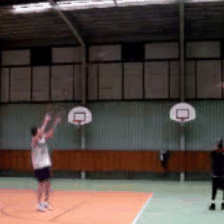

In [43]:
video_tensor = sample['video']
display_gif(video_tensor, image_mean, image_std)

In [24]:
video_tensor_batch = video_tensor.permute(1, 0, 2, 3).unsqueeze(0)

video_tensor_batch.shape

torch.Size([1, 16, 3, 224, 224])

In [29]:
with torch.no_grad():
    video_embed = model(pixel_values=video_tensor_batch).last_hidden_state

video_embed.shape

torch.Size([1, 1568, 768])